In [1]:
import os
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200


In [3]:
@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

## Data

In [246]:
with open('../msprime_sims/bgs_rec_1rep_linear.pkl', 'rb') as f:
    params, bhats = pickle.load(f)
X = np.array(params)
#y = np.log10(np.array(bhats).mean(axis=1))
#y = np.log10(np.array(bhats))
y = np.array(bhats)

In [4]:
sim_data = np.load('../data/slim_sims/B_data.npz', allow_pickle=True)

In [5]:
sim_data['features'], sim_data['X'].shape

(array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'),
 (23024, 7))

In [6]:
X, y = np.array(sim_data['X']), sim_data['y']

In [7]:
(X[:, 1] > 1e-3).mean()

0.9904013203613621

In [8]:
X

array([[1.4375e+04, 2.7940e-02, 5.0000e-01, ..., 8.6820e-04, 3.0270e-08,
        2.4690e+03],
       [1.5289e+04, 5.8160e-02, 5.0000e-01, ..., 2.2520e-02, 1.3430e-07,
        1.1550e+03],
       [1.2814e+04, 5.7870e-02, 5.0000e-01, ..., 1.4890e-07, 1.7340e-07,
        6.2690e+03],
       ...,
       [1.0501e+04, 8.8720e-02, 5.0000e-01, ..., 4.0460e-02, 2.1740e-07,
        9.1000e+02],
       [1.3274e+04, 6.8550e-03, 5.0000e-01, ..., 1.0240e-03, 1.7630e-07,
        1.0220e+03],
       [1.0388e+04, 7.6020e-02, 5.0000e-01, ..., 1.7920e-03, 1.2630e-07,
        2.7150e+03]])

In [14]:
# 0   1  2  3  4  5
# mu  s  r  N  L  nreps

#X_train, X_test, y_train, y_test = train_test_split(X[:, (0, 1, 3, 4, 5, 6)], y[:, 1],  test_size=0.10, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X[:, :4], y,  test_size=0.10, random_state=1)
X_scaler = StandardScaler().fit(X_train)
X_train_normalized = X_scaler.transform(X_train)

In [15]:
X_train.min(axis=0), X_train.max(axis=0), 

(array([1.000e+02, 1.022e-05, 5.000e-01, 1.002e-09]),
 array([1.7206e+04, 1.0000e-01, 5.0000e-01, 9.9960e-08]))

In [16]:
X_test_normalized = X_scaler.transform(X_test)

In [17]:
def network():
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(4,)))
    #model.add(layers.BatchNormalization(axis=1))
    for i in range(4):
        model.add(layers.Dense(64, activation='elu'))
        #model.add(layers.Dropout(0.2))
    for i in range(2):
        model.add(layers.Dense(32, activation='elu'))
        #model.add(layers.Dropout(0.2))
    #model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1, activation='elu'))    
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [18]:
model = network()
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
history = model.fit(X_train_normalized, y_train, 
                    validation_split=0.1, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=64, epochs=500, verbose=0, callbacks=[es])

2022-03-12 10:53:29.111172: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-12 10:53:30.970805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5965 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-03-12 10:53:30.972176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6654 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5


Restoring model weights from the end of the best epoch: 32.
Epoch 00082: early stopping


In [22]:
predict = model.predict(X_test_normalized)

ValueError: x and y must be the same size

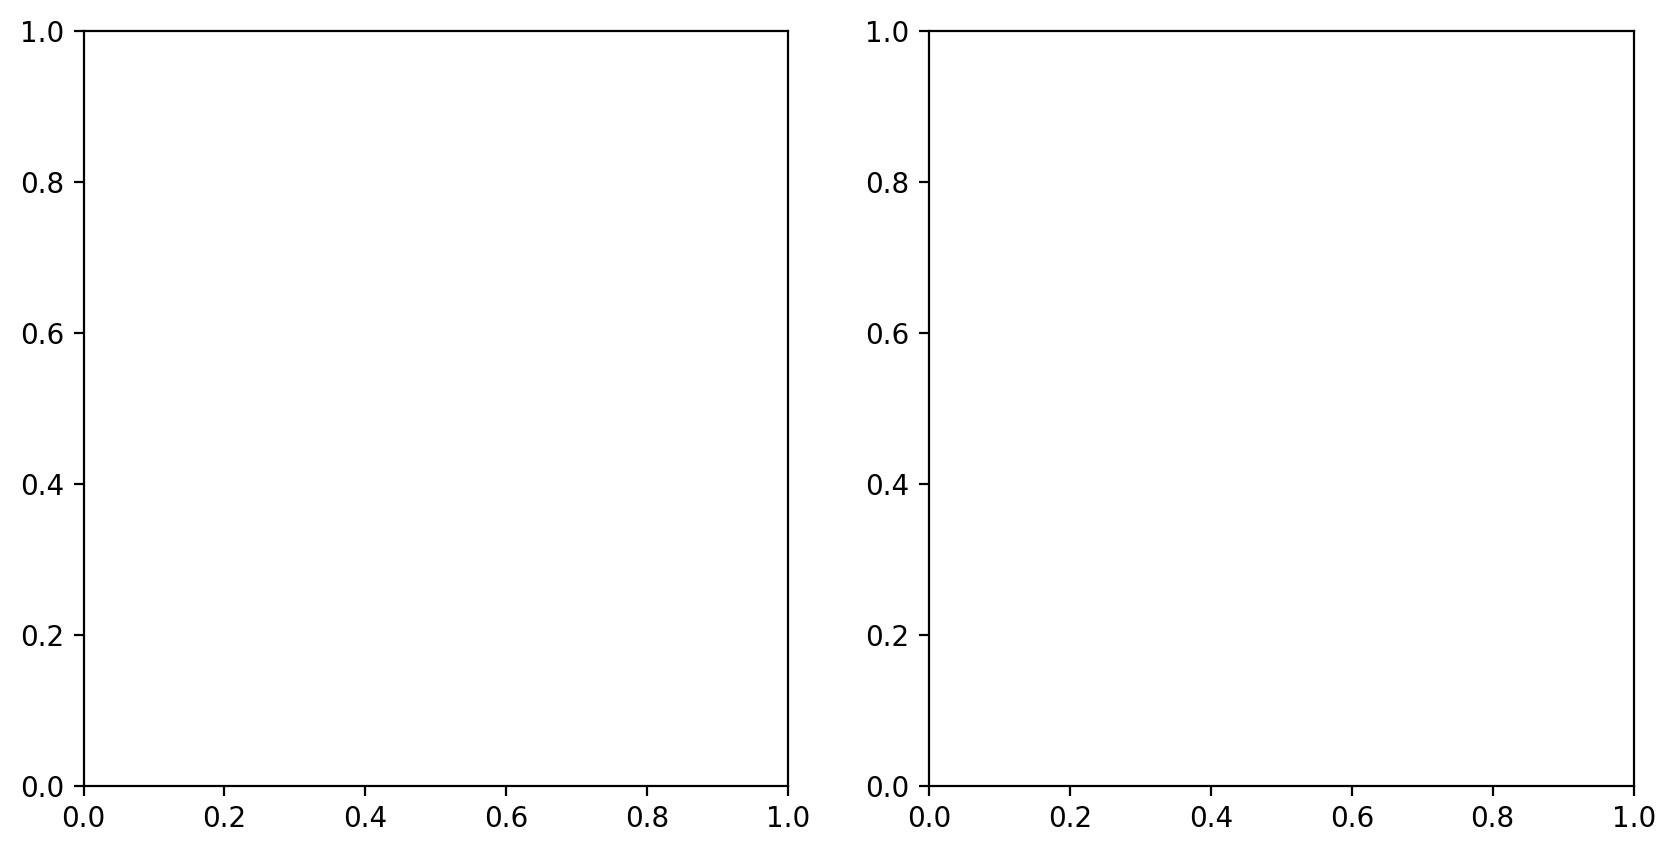

In [23]:
#y_theory = bgs_rec(X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 4])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.scatter(X_test[:, 0]/X_test[:, 1], y_test)
ax1.scatter(y_test, predict, alpha=0.1)
ax1.axline((0, 0), slope=1, c='r')
ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")
#ax2.set_ylim((0, 1))
ax2.legend()

In [244]:
model.evaluate(X_test_normalized, y_test)

72/72 [==============================] - 0s 2ms/step - loss: 0.2131 - mean_absolute_error: 0.3561


[0.21310961246490479, 0.35612931847572327]

In [55]:
model.evaluate(X_test_normalized, y_test)

3125/3125 [==============================] - 5s 2ms/step - loss: 0.1446 - mean_absolute_error: 0.2683


[0.1446310430765152, 0.2682616710662842]

In [170]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(5.392334013709564e-06, 0.9286115050067685)

In [171]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(5.392334013709564e-06, 0.9286115050067685)

(array([  86., 1026., 3738., 6127., 5709., 3269., 1272.,  295.,   27.,
           8.]),
 array([-0.62505611, -0.48181238, -0.33856864, -0.1953249 , -0.05208117,
         0.09116257,  0.23440631,  0.37765004,  0.52089378,  0.66413752,
         0.80738125]),
 <BarContainer object of 10 artists>)

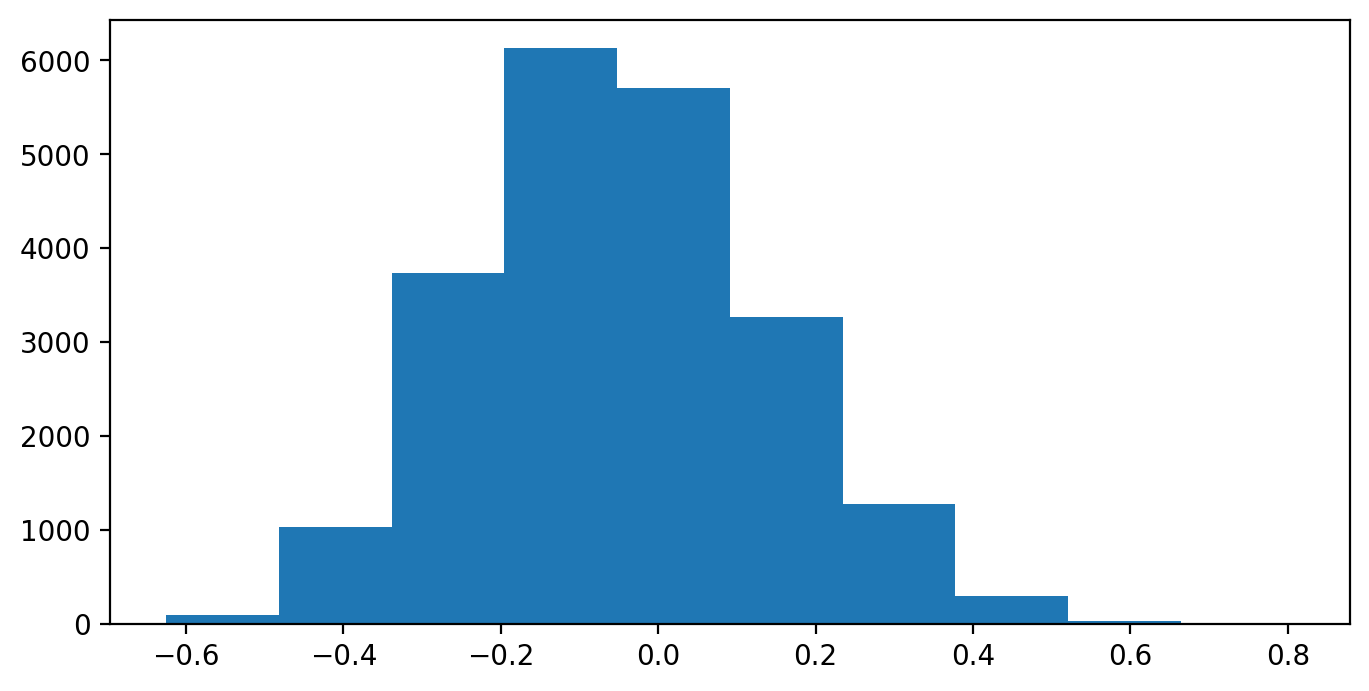

In [202]:
fig, ax = plt.subplots()
ax.hist(np.log10(y[:, 1].flatten()))

Text(0, 0.5, 'B')

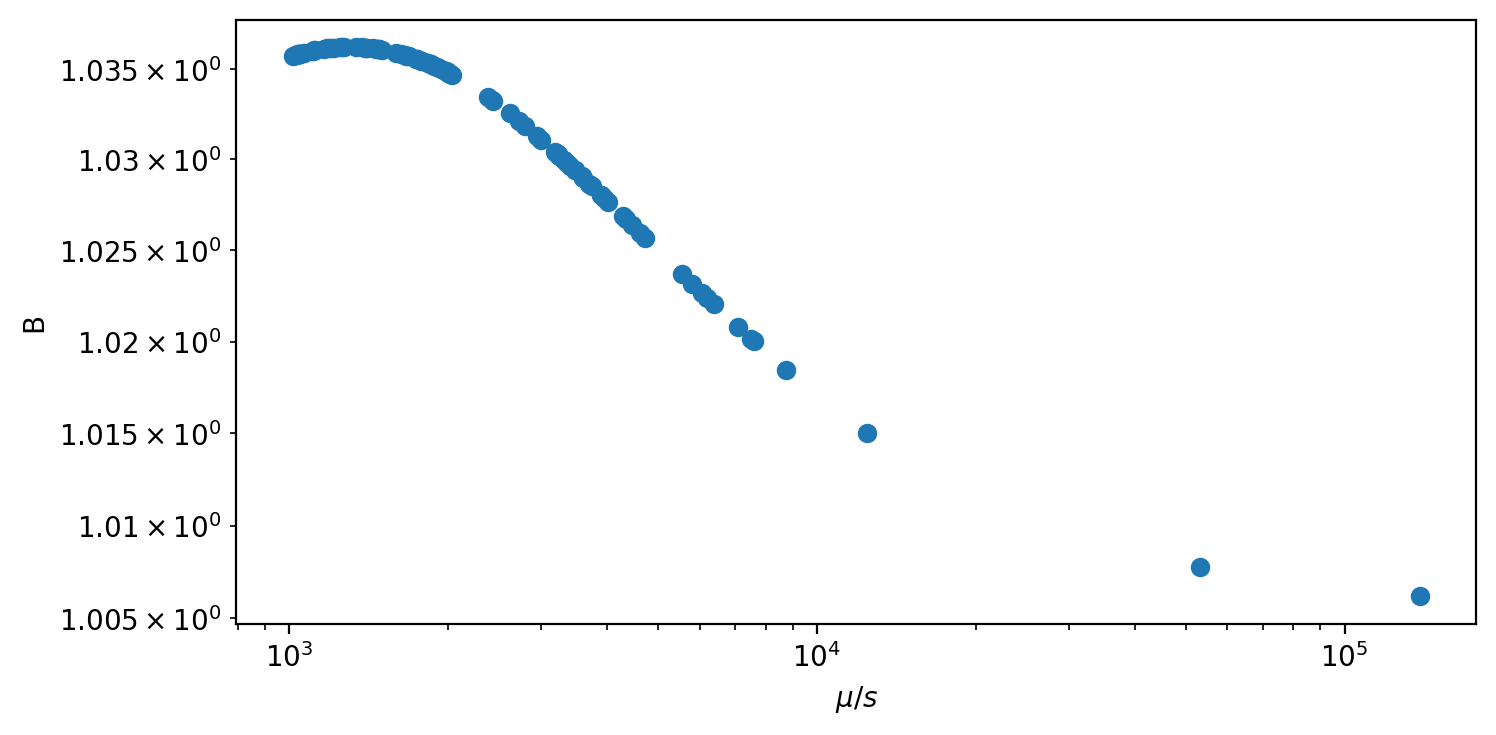

In [245]:
n = 100
mu = np.random.uniform(1e-8, 1e-8, n)
s = np.random.uniform(1e-6, 1e-1, n)
#rbp = np.random.uniform(1e-7, 1e-9, n)
rbp = np.repeat(1e-8, n)
#recfrac = np.random.uniform(1e-7, 1e-3, n)
recfrac = np.repeat(1e-8, n)
#L = np.random.uniform(10, 100_000, n)
L = np.repeat(1000, n)
#N = np.random.uniform(50, 10_000, n)
N = np.repeat(100, n)
#xnew = np.array((mu, s, rbp, N, L)).T
#'N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'
xnew = np.array((N, s, mu, recfrac, rbp, L)).T
rate = xnew[:, 0]/xnew[:, 1]
fig, ax = plt.subplots()
ax.scatter(rate, model.predict(X_scaler.transform(xnew)))
#ax.scatter(rate, bgs_rec(mu, s, rbp, L))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mu/s$')
ax.set_ylabel('B')

In [105]:
tf.reduce_mean(np.abs(predict.flatten() - y_theory.flatten()))

<tf.Tensor: shape=(), dtype=float64, numpy=0.007151165998975198>

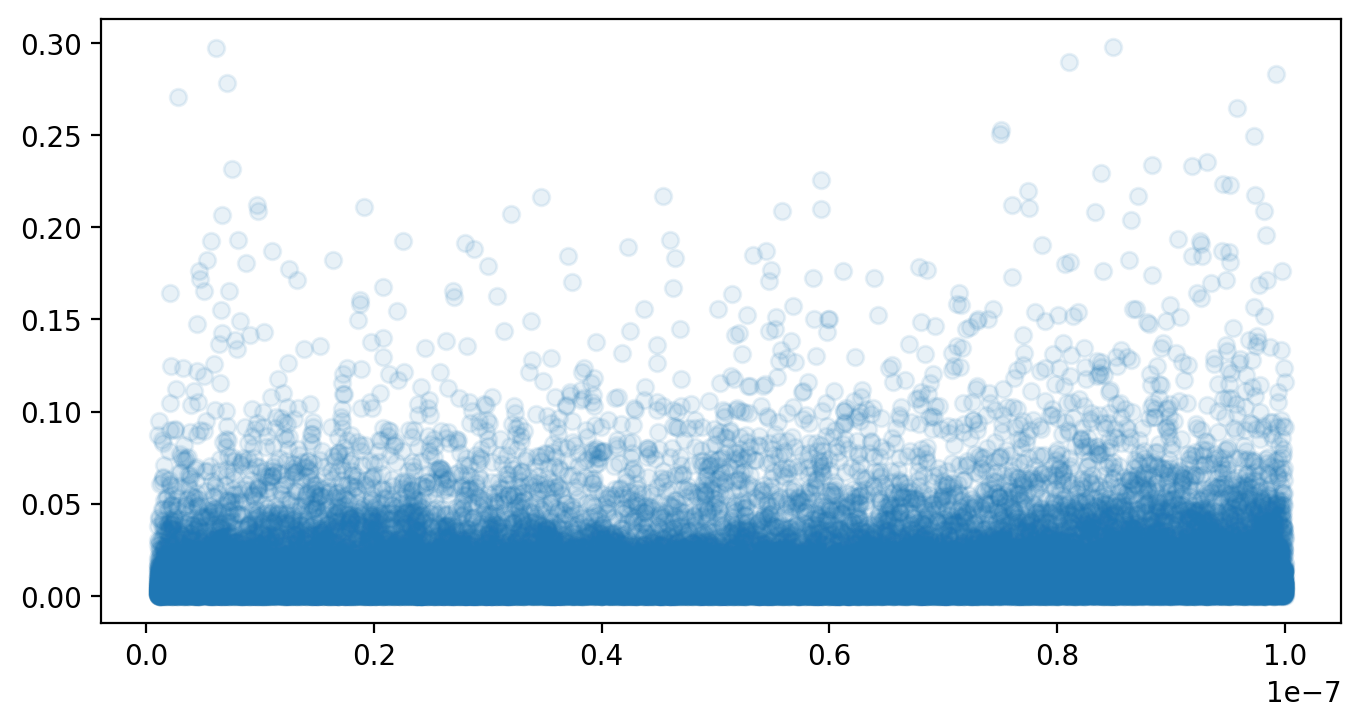

In [ ]:
plt.scatter(X_test[:, 3], np.abs(predict.flatten() - y_theory.flatten()), alpha=0.1)